# Introduction

As someone who has always enjoyed exploring new restaurants and dishes I’m constantly on the lookout for the best dining experiences. However relying solely on ratings can be misleading, especially when restaurants with very few reviews have excessively high scores. This inspired me to analyze restaurants in Stockholm and build a more balanced ranking system using Bayesian averages. The goal is to identify the city’s best restaurants by combining ratings with review counts, creating fair and reliable rankings. With this blog post, I hope to discover the best restaurants in Stockholm and share insights that will appeal to food junkies like me.

# Collecting Data Using APIs

To find the best restaurants in Stockholm using a balanced ranking system, I needed reliable data. Instead of using a pre-made dataset I chose to collect the data myself using publicly available APIs, since it allowed me to customize the dataset to fit my needs and ensure it was up-to-date. I started by using the Yelp Fusion API to collect data on restaurants, choosing columns like 'rating', 'reviews', 'review count' and 'address'. The Yelp API can return up to 240 results per search, with a maximum of 50 results per request. To get the next set of results, I used the offset parameter. I chose to request 48 results at a time to stay within the 240-result limit as requesting 50 would have caused an error. I made multiple requests using the term "restaurants" and location set to "Stockholm" and then organized the data into a pandas DataFrame to visualize the results in a table. 

In [271]:
import requests
import pandas as pd
import time

# API-key from Yelp
API_KEY = "x"

# API URL och headers
url = "https://api.yelp.com/v3/businesses/search"
headers = {"Authorization": f"Bearer {API_KEY}"}

restaurants = []

# Fetches restaurants in batches of 48
for offset in range(0, 240, 48): 
    params = {
        "term": "restaurants",  
        "location": "Stockholm",  
        "limit": 48,  
        "offset": offset 
    }
    response = requests.get(url, headers=headers, params=params)
    
    # Verify if the request was successful 
    if response.status_code == 200:
        data = response.json()
        for biz in data["businesses"]:
            restaurants.append({
                "Name": biz["name"],
                "Rating": biz["rating"],
                "Reviews": biz["review_count"],
                "Address": ", ".join(biz["location"]["display_address"])
            })
    else:
        print("Error:", response.status_code)
        break

# Create a dataframe and visualize it
df_yelp = pd.DataFrame(restaurants)
df_yelp.head(10)


,Name,Rating,Reviews,Address
0,Bakfickan,4.3,270,"Jakobs torg 12, 111 52 Stockholm, Sweden"
1,Panda,4.3,37,"Vasag. 12, 111 20 Stockholm, Sweden"
2,Bistro Bestick,4.7,153,"Bryggargatan 8, 111 21 Stockholm, Sweden"
3,The Fishery Brunkebergstorg,4.8,6,"Brunkebergstorg 14, 111 51 Stockholm, Sweden"
4,The Hairy Pig Deli,4.7,186,"Osterlanggatan 9, Gamla Stan, 111 30 Stockhol..."
5,Matgatan 22,4.6,33,"Stora Nygatan 22, 111 27 Stockholm, Sweden"
6,Tegelbacken,4.9,11,"Tegelbacken 2, 111 52 Stockholm, Sweden"
7,Aifur,4.3,120,"Västerlånggatan 68 B, 111 29 Stockholm, Sweden"
8,Da Peppe Ristorante,4.4,64,"Storkyrkobrinken 16, 111 28 Stockholm, Sweden"
9,Viking Bar,4.3,19,"Hornsgatan 37, 118 49 Stockholm, Sweden"


I quickly realised that 240 restaurants wouldn't be enough to accurately represent the restaurants in Stockholm so I decided to use Google Maps Places API to make the dataset more robust. The Google Places API only returns 20 restaurants per request with a maximum of 60 results in total using pagination. To work around this limitation I specified different areas in Stockholm, such as Södermalm, Norrmalm, Östermalm, Gamla Stan and Kungsholmen, where I managed to fetch data for 285 restaurants. However, the function returned a different number of results each time it was run. According to discussions from Stack Overflow, this is likely due to Google's algorithms which functions like a black box, giving different results based on location and other parameters. To make sure pagination works well, I used time.sleep(2) delay between requests to ensure that the API had enough time to return complete results from the API before fetching the next page. 

In [272]:
# API Key from Google
GOOGLE_API_KEY = "x"

def fetch_google_restaurants(query):
    """Fetches restaurant data from Google Places API with pagination.""" 
    url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
    restaurants = []
    params = {"query": query, "key": GOOGLE_API_KEY}

    while True:
        # Send request to Google API
        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"Error fetching data: {response.status_code}")
            break

        # Extract and organize restaurant details
        data = response.json()
        results = data.get("results", [])
        restaurants.extend([{
            "Name": place["name"],
            "Google_Rating": place.get("rating"),
            "Google_Reviews": place.get("user_ratings_total"),
            "Address": place.get("formatted_address")
        } for place in results])

        # Fetch next paige if possible
        next_page_token = data.get("next_page_token")
        if not next_page_token:
            break
        params["pagetoken"] = next_page_token
        time.sleep(2)  # Wait before fetching the next page
  
    return pd.DataFrame(restaurants)

def fetch_all_google_restaurants(areas):
    """Fetches restaurant data for multiple areas and combines the results."""
    all_restaurants = []
    for area in areas:
        query = f"restaurants in {area}, Stockholm"
        all_restaurants.append(fetch_google_restaurants(query))

    # Combine all areas and remove duplicates
    return pd.concat(all_restaurants, ignore_index=True).drop_duplicates(subset="Name")

# Areas in Stockholm to find restaurants
areas = ["Södermalm", "Norrmalm", "Östermalm", "Gamla Stan", "Kungsholmen"]
df_all_google = fetch_all_google_restaurants(areas)

# Display results and the number of restaurants fetched
print(f"Total number of restaurants: {len(df_all_google)}")
df_all_google.head(10)

Total number of restaurants: 285


,Name,Google_Rating,Google_Reviews,Address
0,Restaurant Pelikan,4.4,4296,"Blekingegatan 40, 116 62 Stockholm, Sweden"
1,Stockholms Gästabud,4.7,5280,"Österlånggatan 7, 111 31 Stockholm, Sweden"
2,Restaurant Esperia,4.5,1435,"Sankt Paulsgatan 17, 118 46 Stockholm, Sweden"
3,Blå dörren,4.4,3666,"Södermalmstorg 6, 116 45 Stockholm, Sweden"
4,Woodstockholm,4.6,773,"Mosebacke Torg 9, 116 46 Stockholm, Sweden"
5,Restaurant O'PIZZICATO,4.6,1475,"Swedenborgsgatan 23, 118 27 Stockholm, Sweden"
6,Maestro,4.7,1321,"Ringvägen 82, 118 60 Stockholm, Sweden"
7,Restaurant Akkurat - Södermalm,4.4,4138,"Hornsgatan 18, 118 20 Stockholm, Sweden"
8,Hermans,4.6,4839,"Fjällgatan 23B, 116 28 Stockholm, Sweden"
9,Restaurang Kryp In Södermalm,4.9,512,"Timmermansgatan 22, 118 55 Stockholm, Sweden"


# Combining the Datasets

I now had two DataFrames, one for Yelp data and one for Google data. However the column names for ratings and reviews were different between the two datasets so I renamed the Google columns to match those in the Yelp dataset. I then combined both datasets into a single DataFrame using pd.concat(). Since the datasets contained duplicates, I chose to only keep the entries from Google, which will unlikely to have a notable impact since both datasets are similar in terms of coverage and quality. I then displayed the combined data to get an overview and checked for issues such as NaN values or inconsistencies that could make the dataset unclean. To verify that I had handled the data correctly I used df_combined.isnull().sum() to summarize any missing values, df_combined['Rating'].between(0,5).all() to ensure all the rating values are in the expected range of 0 to 5, and df_combined.duplicated.sum() to check if there are any duplicated rows.  As the checks showed that the dataset was clean, I then moved on to create a scoring function. 

In [273]:
# Rename columns in Google dataset to match Yelp dataset
df_all_google.rename(columns={
    "Google_Rating": "Rating",
    "Google_Reviews": "Reviews"
}, inplace=True)

# Combine Yelp and Google datasets and prioritize Google data in case of duplicates
df_combined = pd.concat([df_yelp, df_all_google], ignore_index=True).drop_duplicates(subset=["Name", "Address"], keep="last")

# Display results and print the number of restaurants
print(f"Total number of restaurants after combining: {len(df_combined)}")
df_combined


Total number of restaurants after combining: 525


,Name,Rating,Reviews,Address
0,Bakfickan,4.3,270,"Jakobs torg 12, 111 52 Stockholm, Sweden"
1,Panda,4.3,37,"Vasag. 12, 111 20 Stockholm, Sweden"
2,Bistro Bestick,4.7,153,"Bryggargatan 8, 111 21 Stockholm, Sweden"
3,The Fishery Brunkebergstorg,4.8,6,"Brunkebergstorg 14, 111 51 Stockholm, Sweden"
4,The Hairy Pig Deli,4.7,186,"Osterlanggatan 9, Gamla Stan, 111 30 Stockhol..."
...,...,...,...,...
520,Restaurang Gandhi,4.0,352,"Hantverkargatan 80, 112 38 Stockholm, Sweden"
521,BrewDog Kungsholmen,4.1,1328,"Sankt Eriksgatan 56, 112 34 Stockholm, Sweden"
522,El Cielo,4.0,1310,"Fleminggatan 22a, 112 32 Stockholm, Sweden"
523,The Good Gringo,4.3,187,"Scheelegatan 28, 112 28 Stockholm, Sweden"


# Developing a Balanced Scoring System

Since a high rating with only a few reviews doesn’t give much information about the restaurants quality, I needed a scoring function that considers both the rating and the number of reviews when calculating a restaurant’s final rating. For this purpose I decided to use the Bayesian Average, which balances individual restaurant data with the overall global average rating from the dataset. The formula for the Bayesian Average is:
$$ 
\text{Bayesian Average} = \frac{(n \cdot r) + (m \cdot \text{global\_avg})}{n + m}. 
$$
Here $r$ represents the restaurant's average rating, $n$ the number of reviews and $global_avg$ the average rating across all restaurants in the combined dataset. $m$ in this case, is a parameter that controls how much weight is given to the global average compared to each restaurant's data. The parameter is chosen based on the number of reviews in the dataset, where a higher $m$ gives more weight to the global average, which is suitable when restaurants have few reviews. Similarly, a lower $m$ means that each restaurant's rating has a greater impact, which is appropriate when restaurants have a higher number of reviews. To find a suitable value for $m$, I evaluated the number of reviews by using df_combined["Reviews"].describe(). This revealed that the median number of reviews was 187. I chose $m=100$ as a balanced option, since it prevents restaurants with few reviews from ranking too high will also letting restaurants with many reviews to stand out.  
$$$$$$$$

In [281]:
# Function to calculate Bayesian Average
def calculate_bayesian_score(row, global_avg, m):
    """Calculate Bayesian Average for a single row."""
    n = row["Reviews"]  # Adjust with the actual column name for the number of reviews
    r = row["Rating"]  # Adjust with the actual column name for the average rating
    return ((n * r) + (m * global_avg)) / (n + m)

# Calculate global average and define weight
global_avg = df["Rating"].mean()  
m = 100 

# Apply Bayesian Average Scoring
df_combined["Bayesian_score"] = df_combined.apply(calculate_bayesian_score, axis=1, global_avg=global_avg, m=m)
df_combined

,Name,Rating,Reviews,Address,Bayesian_score
0,Bakfickan,4.3,270,"Jakobs torg 12, 111 52 Stockholm, Sweden",4.283671
1,Panda,4.3,37,"Vasag. 12, 111 20 Stockholm, Sweden",4.255900
2,Bistro Bestick,4.7,153,"Bryggargatan 8, 111 21 Stockholm, Sweden",4.518017
3,The Fishery Brunkebergstorg,4.8,6,"Brunkebergstorg 14, 111 51 Stockholm, Sweden",4.271305
4,The Hairy Pig Deli,4.7,186,"Osterlanggatan 9, Gamla Stan, 111 30 Stockhol...",4.539015
...,...,...,...,...,...
520,Restaurang Gandhi,4.0,352,"Hantverkargatan 80, 112 38 Stockholm, Sweden",4.053005
521,BrewDog Kungsholmen,4.1,1328,"Sankt Eriksgatan 56, 112 34 Stockholm, Sweden",4.109775
522,El Cielo,4.0,1310,"Fleminggatan 22a, 112 32 Stockholm, Sweden",4.016992
523,The Good Gringo,4.3,187,"Scheelegatan 28, 112 28 Stockholm, Sweden",4.278949


In [277]:
# Sort by Bayesian score and select the top 10 restaurants
top_restaurants = df_combined.sort_values(by="Bayesian_score", ascending=False).head(20)

# Reset the index to start from 1
top_restaurants = top_restaurants.reset_index(drop=True)
top_restaurants.index += 1  

# Select specific columns for display 
columns = ["Name", "Bayesian_score", "Rating", "Reviews", "Address"]

# Display the top restaurants
top_restaurants[columns]


,Name,Bayesian_score,Rating,Reviews,Address
1,Aleks y Filip,4.819461,4.9,720,"Bjälbogatan 32, 118 66 Stockholm, Sweden"
2,Restaurang Kryp In Södermalm,4.792089,4.9,512,"Timmermansgatan 22, 118 55 Stockholm, Sweden"
3,Mae Thai Hötorget,4.755345,4.8,1155,"Hötorget 12, 111 57 Stockholm, Sweden"
4,FIKA & WINE,4.737801,4.8,801,"Österlånggatan 5, 111 31 Stockholm, Sweden"
5,Tajrish restaurang,4.736531,4.9,304,"Torsgatan 31, 113 21 Stockholm, Sweden"
6,The kulture,4.729772,4.8,698,"Fridhemsgatan 3, 112 40 Stockholm, Sweden"
7,Adam/Albin,4.720957,4.8,609,"Rådmansgatan 16, 114 25 Stockholm, Sweden"
8,Cong,4.720055,4.8,601,"Kornhamnstorg 51, 111 27 Stockholm, Sweden"
9,Aama Himalayan Kitchen Stockholm,4.718068,4.8,584,"Fridhemsgatan 15, 112 40 Stockholm, Sweden"
10,Mormors Lilla Kök,4.712572,4.8,541,"Rosenlundsgatan 23, 118 63 Stockholm, Sweden"


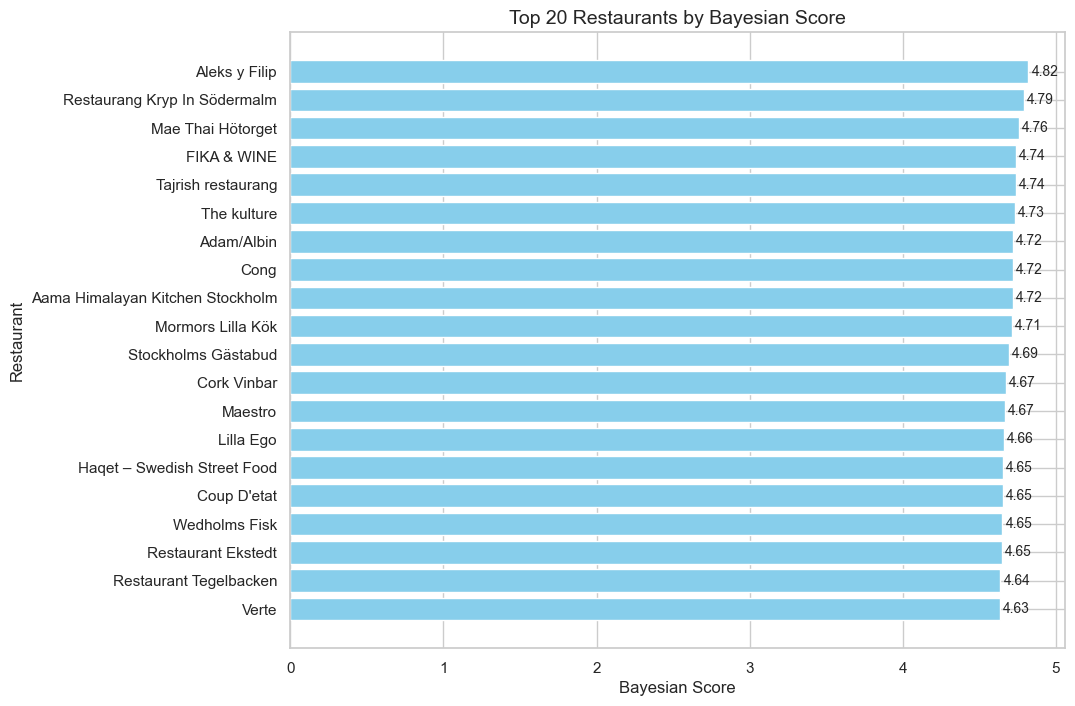

In [278]:
# Create a bar chart
plt.figure(figsize=(10, 8))
bars = plt.barh(top_restaurants["Name"], top_restaurants["Bayesian_score"], color="skyblue")
plt.xlabel("Bayesian Score", fontsize=12)
plt.ylabel("Restaurant", fontsize=12)
plt.title("Top 20 Restaurants by Bayesian Score", fontsize=14)
plt.gca().invert_yaxis()  # Reverse order for better readability

# Add annotations
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2, f"{width:.2f}", va='center', fontsize=10)

plt.show()


In [ ]:
Maybe analyze how the Bayesian Average changes the rating. 